# Colocalization analysis
We will use the function `spatial_interaction` from the package `scimap`, and a modification of the function, `directionalSEA` (SEA = spatial enrichment analysis) (Schiller et al., unpublished).

The goal is
1) to statistically analyze some spatial patterns that Kuett et al. (2021) observed by eye:
    - "clear tendency of CD45+CD3+ T cells (cluster 13 and 18) to cluster around the vWF+CD31+ endothelial cells (cluster 21)"
    - "spatial separation of different subsets of CD68+ cells (clusters 30 and 28)"
1) compare results obtained on 2D and 3D data, and 
1) if possible, gain further biological insights (based on phenotypes defined before)

In [1]:
## Imports
import scimap as sm
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import time

Running SCIMAP  2.1.3


/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
## Load data

cluster_labels = pd.read_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/model201710_cluster_labels_phenograph_recoded.csv')
fn_2D = "../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_centroids_2D/measured_mask_centroids_2D_*.csv"
files_2D = np.array(glob.glob(fn_2D)) ## unsorted list of files (full path)
centroids_2D = pd.concat([pd.read_csv(file) for file in files_2D])
centroids_3D = pd.read_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_centroids_3D.csv')

centroids_2D.sort_values(by='z', inplace=True)
## Recode cluster labels to avoid conversion to int in sm function (issue opened)
cluster_labels.loc[ cluster_labels['ct_broad'].isna(), 'ct_broad' ] = 'label_' + cluster_labels.loc[ cluster_labels['ct_broad'].isna(), 'phenograph' ].astype(str)
## Recode cluster labels for observed spatial patterns
cluster_labels['pattern1'] = cluster_labels['phenograph'].map({13:'T',18:'T',21:'endothelial'}).fillna('other')
cluster_labels['pattern2'] = cluster_labels['phenograph'].map({30:'subtype_A',28:'subtype_B'}).fillna('other')
## Group T cell subtypes together (T, T_CD8a-)
#cluster_labels.loc[ cluster_labels['ct_broad']=='T_CD8a-', 'ct_broad' ] = 'T'

## Merge cluster labels with centroids
data2D = pd.merge(centroids_2D, cluster_labels, on='id') ## id = cell id, z = imageid
data3D = pd.merge(centroids_3D, cluster_labels, on='id') ## id = cell id
data3D['imageid'] = np.repeat('imageid', data3D.shape[0]) ## placeholder

## In slices with only one cell per phenotype, remove that cell
## to avoid error in sm function (issue opened)
## This is not ideal, as it changes the 2D, but not 3D data
single_entries = data2D.groupby(['z', 'ct_broad']).filter(lambda x: len(x) == 1)
data2D = data2D.drop(single_entries.index)
print(f'Removed {single_entries.shape[0]} single entries from 2D data')

## To AnnData object
adata2 = ad.AnnData(obs=data2D)
adata3 = ad.AnnData(obs=data3D)

Removed 56 single entries from 2D data


/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.



In [3]:
## Get NBH size equivalent
knn_2D = 5
knn2to3 = pd.read_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/knn_2D_to_3D.csv')
knn_3D = knn2to3.loc[ knn2to3['knn_2D'] == knn_2D, 'knn_3D'].values[0]
knn_3D

17

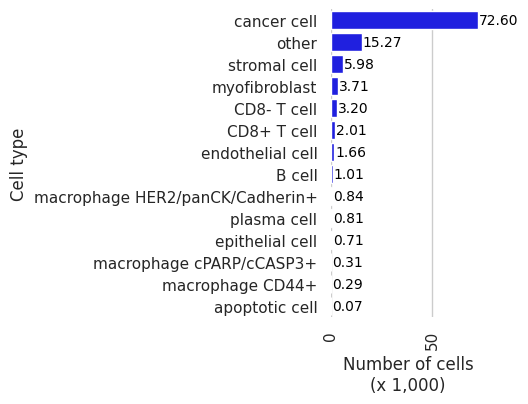

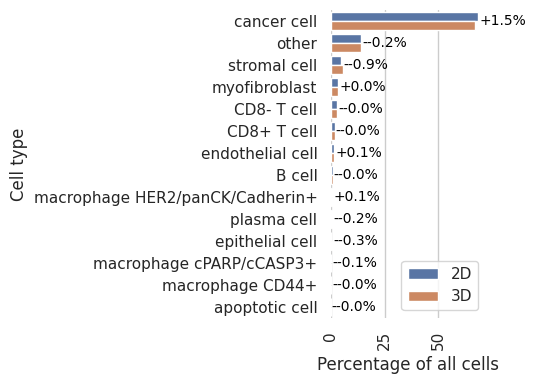

In [32]:
## Plot cell type abundances

counts = pd.merge(adata2.obs['ct_broad'].value_counts(),
                adata3.obs['ct_broad'].value_counts(),
                left_index=True, right_index=True, suffixes=('_2D', '_3D'))
counts.sort_values(by='count_3D', ascending=False, inplace=True)
counts.columns = ['2D', '3D']

## Barplot with ('true') 3D counts
sns.set_theme(style="whitegrid")
plt.subplots(figsize=(2, 4))
sns.barplot(x=counts['3D'] / 1000, y=counts.index, color='blue')
plt.ylabel('Cell type')
plt.xlabel('Number of cells\n(x 1,000)')
plt.xticks(rotation=90)
sns.despine(left=True, bottom=True)

for idx, (index, row) in enumerate(counts.iterrows()):
    text = f'{(row["3D"]/1000):.2f}'
    plt.text(
        (row['3D']/1000) + 0.5,  # position text slightly to the right of the longest bar
        idx,              # y-position is the index in the DataFrame
        text,
        va='center',
        ha='left',
        color="black",
        fontsize=10,
    )
plt.show()


## Barplot with percentages in 2D & 3D
#counts['diff_abs'] = counts['2D'] - counts['3D'] ## difference in counts
#counts['sign'] = counts['diff_abs'].apply(lambda x: "+" if x > 0 else "-") ## sign of difference
#counts['diff_rel'] = counts['diff_abs'] / counts['3D'] * 100 ## difference as fraction
counts[['2D', '3D']] = counts[['2D', '3D']] / counts[['2D', '3D']].sum() * 100  ## to fraction
counts['diff_rel'] = counts['2D'] - counts['3D'] ## difference in fractions
counts['sign'] = counts['diff_rel'].apply(lambda x: "+" if x > 0 else "-") ## sign of difference
fractions = counts[['2D','3D']].reset_index(drop=False).melt(id_vars='ct_broad', var_name='dimensionality', value_name='value')

plt.subplots(figsize=(2, 4))
sns.barplot(data=fractions,  x='value', y='ct_broad', hue='dimensionality') # color='lightgrey')
#sns.barplot(data=counts, x='count_2D', y=counts.index, color='black')
plt.xticks(rotation=90)
plt.ylabel('Cell type')
plt.xlabel('Percentage of all cells')
plt.legend(loc='lower right')
sns.despine(left=True, bottom=True)

for idx, (index, row) in enumerate(counts.iterrows()):
    #difference_text = f"{row['sign']}{abs(row['diff_abs']):,} ({row['diff_rel']:.0f}%)"
    difference_text = f"{row['sign']}{row['diff_rel']:.1f}%"
    max_value = max(row['2D'], row['3D'])
    plt.text(
        max_value + 0.5,  # position text slightly to the right of the longest bar
        idx,              # y-position is the index in the DataFrame
        difference_text,
        va='center',
        ha='left',
        color="black",
        fontsize=10,
    )
sns.set_theme() ## reset theme

## Using scimap's `spatial_interaction`

### Phenotypes from Kuett et al. (2021)

In [3]:
## Remove cells that only have one cell per slice
## Here, this is the case for pattern2

single_entries = data2D.groupby(['z', 'pattern2']).filter(lambda x: len(x) == 1)
data2D_p2 = data2D.drop(single_entries.index)
adata2_p2 = ad.AnnData(obs=data2D_p2)

single_entries = data3D.groupby(['imageid', 'pattern2']).filter(lambda x: len(x) == 1)
data3D_p2 = data3D.drop(single_entries.index)
adata3_p2 = ad.AnnData(obs=data3D_p2)

/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.



In [4]:
## Spatial interaction based on phenotypes from pattern1 (T cells, endothelial cells)
## Calculate spatial interaction in 2D
t0 = time.process_time()
sm.tl.spatial_interaction(adata2, x_coordinate='x', y_coordinate='y', z_coordinate=None, imageid='z',
                          phenotype='pattern1', label='spatial_interaction_pattern1',
                          method='knn', knn=knn_2D, permutation=1000, pval_method='zscore', verbose=False)
print("Time elapsed for 2D: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

## Calculate spatial interaction in 3D
t0 = time.process_time()
sm.tl.spatial_interaction(adata3, x_coordinate='x', y_coordinate='y', z_coordinate='z', imageid='imageid',
                          phenotype='pattern1', label='spatial_interaction_pattern1',
                          method='knn', knn=knn_3D, permutation=1000, pval_method='zscore', verbose=False)
print("Time elapsed for 3D: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

NameError: name 'knn_2D' is not defined

In [113]:
## Spatial interaction based on phenotypes from pattern2 (CD68+ subtypes)
## Calculate spatial interaction in 2D
t0 = time.process_time()
#sm.tl.spatial_interaction(adata2_p2, x_coordinate='x', y_coordinate='y', z_coordinate=None, imageid='z',
#                          phenotype='pattern2', label='spatial_interaction_pattern2',
#                          method='knn', knn=knn_2D, permutation=1000, pval_method='zscore', verbose=False)
print("Time elapsed for 2D: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

## Calculate spatial interaction in 3D
t0 = time.process_time()
sm.tl.spatial_interaction(adata3_p2, x_coordinate='x', y_coordinate='y', z_coordinate='z', imageid='imageid',
                          phenotype='pattern2', label='spatial_interaction_pattern2',
                          method='knn', knn=knn_3D, permutation=1000, pval_method='zscore', verbose=False)
print("Time elapsed for 3D: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

Time elapsed for 2D:  00:00:00
Time elapsed for 3D:  00:07:20


In [115]:
## Save results
adata2.uns['spatial_interaction_pattern1'].to_csv('../../data/temp/Kuett_2022_spatial_interaction_pattern1_2D.csv')
adata3.uns['spatial_interaction_pattern1'].to_csv('../../data/temp/Kuett_2022_spatial_interaction_pattern1_3D.csv')
adata2_p2.uns['spatial_interaction_pattern2'].to_csv('../../data/temp/Kuett_2022_spatial_interaction_pattern2_2D.csv')
adata3_p2.uns['spatial_interaction_pattern2'].to_csv('../../data/temp/Kuett_2022_spatial_interaction_pattern2_3D.csv')

In [4]:
## Load results
adata2.uns['spatial_interaction_pattern1'] = pd.read_csv('../../data/temp/Kuett_2022_spatial_interaction_pattern1_2D.csv', index_col=0)
adata3.uns['spatial_interaction_pattern1'] = pd.read_csv('../../data/temp/Kuett_2022_spatial_interaction_pattern1_3D.csv', index_col=0)
adata2_p2.uns['spatial_interaction_pattern2'] = pd.read_csv('../../data/temp/Kuett_2022_spatial_interaction_pattern2_2D.csv', index_col=0)
adata3_p2.uns['spatial_interaction_pattern2'] = pd.read_csv('../../data/temp/Kuett_2022_spatial_interaction_pattern2_3D.csv', index_col=0)

In [22]:
import sys

def spatial_interaction_sub(
    adata: ad.AnnData,
    phenotypes_to_include: list = None,
    include_self_preference: bool = False,
    columns = None,
    xlabel: str = 'Section',
    spatial_interaction: str = 'spatial_interaction',
    p_val: float = None,
    figsize: tuple = None,
    cmap: str = 'vlag',
    annot: bool = False,
    square: bool = False,
    vmin: float = -1,
    vmax: float = 1,
    center: float = 0,
    cbar_kws: dict = {'shrink':.8, 'aspect':5, 'location':'left', 'ticklocation':'right'}
):
    # Get data
    df = sm.pl.spatial_interaction(adata, summarize_plot=False, spatial_interaction=spatial_interaction, p_val=p_val, return_data=True, figsize=(sys.float_info.min, sys.float_info.min))
    # Filter & sort data
    df.reset_index(inplace=True)
    df = df[ df['phenotype'].isin(phenotypes_to_include) & (df['neighbour_phenotype'].isin(phenotypes_to_include)) ]
    if not include_self_preference:
        df = df[ df['phenotype'] != df['neighbour_phenotype'] ]
    df.set_index(['phenotype', 'neighbour_phenotype'], inplace=True)
    if columns is not None:
        df = df[columns]
    # Plot
    if figsize is None:
        figsize = (10,df.index.size*.4)
    cmap_custom = sns.color_palette(cmap, as_cmap=True)
    cmap_custom.set_bad(color='gray')
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df, ax=ax, mask=df.isna(),
                cmap=cmap_custom, annot=annot,  square=square,
                vmin=vmin, vmax=vmax, center=center, cbar_kws=cbar_kws)
    ax.yaxis.tick_right()
    ax.set_yticklabels([ f'{i[0]} - {i[1]}' for i in df.index ]) ## add space between phenotype labels
    plt.yticks(rotation=0, ha='left')
    ax.yaxis.set_label_position("right")
    ax.set_xlabel(xlabel)
    plt.show()

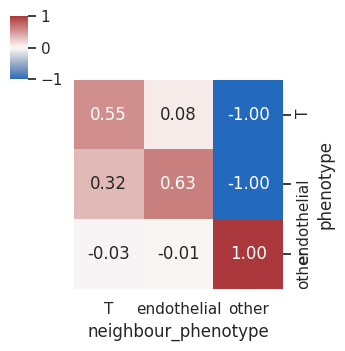

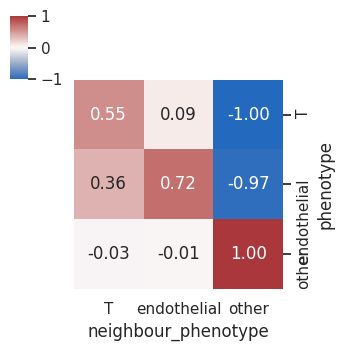

/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/seaborn/matrix.py:1113: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



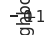

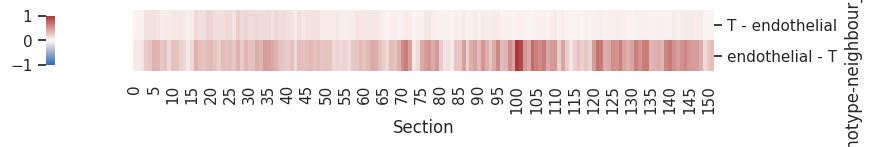

In [23]:
## Assess results
spatial_interaction = 'spatial_interaction_pattern1'

## Plot results using scimap function
sm.pl.spatial_interaction(adata3, spatial_interaction=spatial_interaction,
                          summarize_plot=True, annot=True, fmt=".2f", p_val=None, vmin=-1, vmax=1, figsize=(3.5,3.5))
sm.pl.spatial_interaction(adata2, spatial_interaction=spatial_interaction,
                          summarize_plot=True, annot=True, fmt=".2f", p_val=None, vmin=-1, vmax=1, figsize=(3.5,3.5)) ## Using mean of all slices
spatial_interaction_sub(adata2,
    phenotypes_to_include=['T', 'endothelial'],
    spatial_interaction='spatial_interaction_pattern1',
    columns = adata2.obs['z'].unique().astype(str))

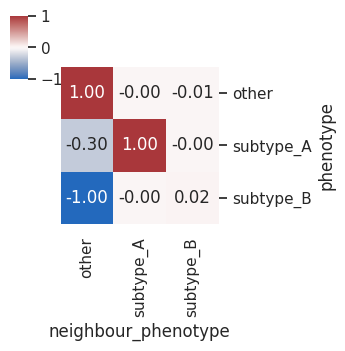

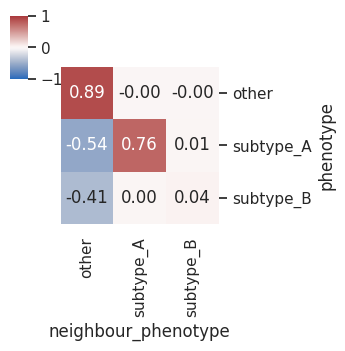

/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/seaborn/matrix.py:1113: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



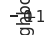

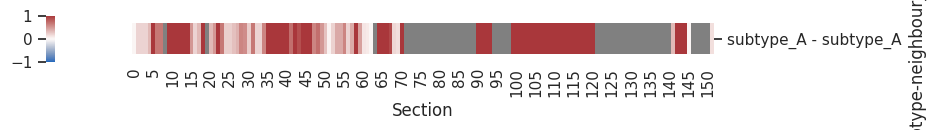

In [24]:
## Assess results
spatial_interaction = 'spatial_interaction_pattern2'

## Plot results using scimap function
sm.pl.spatial_interaction(adata3_p2, spatial_interaction=spatial_interaction,
                          summarize_plot=True, annot=True, fmt=".2f", p_val=None, vmin=-1, vmax=1, figsize=(3.5,3.5))
sm.pl.spatial_interaction(adata2_p2, spatial_interaction=spatial_interaction,
                          summarize_plot=True, annot=True, fmt=".2f", p_val=None, vmin=-1, vmax=1, figsize=(3.5,3.5)) ## Using mean of all slices
spatial_interaction_sub(adata2_p2,
    phenotypes_to_include=['subtype_A'],
    spatial_interaction='spatial_interaction_pattern2',
    include_self_preference=True,
    columns = adata2.obs['z'].unique().astype(str),
    cbar_kws = {'shrink':1.5, 'aspect':5, 'location':'left', 'ticklocation':'right'})

### Own phenotypes

In [4]:
## Spatial interaction based on phenotypes from ct_broad
## Calculate spatial interaction in 2D
t0 = time.process_time()
sm.tl.spatial_interaction(adata2, x_coordinate='x', y_coordinate='y', z_coordinate=None, imageid='z', phenotype='ct_broad',
                          method='knn', knn=knn_2D, permutation=1000, pval_method='zscore', verbose=False)
print("Time elapsed for 2D: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

## Calculate spatial interaction in 3D
t0 = time.process_time()
sm.tl.spatial_interaction(adata3, x_coordinate='x', y_coordinate='y', z_coordinate='z', imageid='imageid', phenotype='ct_broad',
                          method='knn', knn=knn_3D, permutation=1000, pval_method='zscore', verbose=False)
print("Time elapsed for 3D: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

Time elapsed for 2D:  00:08:46
Time elapsed for 3D:  00:06:22


In [68]:
## Save results
adata2.uns['spatial_interaction'].to_csv('../../data/temp/Kuett_2022_spatial_interaction_2D.csv', sep=',', index=False)
adata3.uns['spatial_interaction'].to_csv('../../data/temp/Kuett_2022_spatial_interaction_3D.csv', sep=',', index=False)

In [5]:
## View results table
adata2.uns['spatial_interaction']

,phenotype,neighbour_phenotype,0,pvalue_0,1,pvalue_1,2,pvalue_2,3,pvalue_3,...,147,pvalue_147,148,pvalue_148,149,pvalue_149,150,pvalue_150,151,pvalue_151
0,B cell,B cell,0.250000,5.076859e-21,0.500000,2.097857e-69,-0.000000,9.284797e-01,-0.000000,9.241159e-01,...,0.977778,5.891550e-143,1.000000,2.415403e-132,1.000000,5.599591e-155,0.875000,1.167184e-125,0.400000,1.032606e-31
1,B cell,CD8+ T cell,0.125000,2.388604e-02,0.125000,9.195272e-02,0.250000,7.598988e-03,0.333333,1.581528e-03,...,0.644444,2.561242e-27,0.750000,9.845091e-30,0.543478,4.313322e-16,0.600000,3.861238e-17,0.342857,1.436782e-07
2,B cell,CD8- T cell,0.125000,1.538554e-01,0.500000,2.338212e-08,0.500000,9.654515e-04,0.333333,1.080600e-01,...,0.666667,2.258962e-19,0.875000,2.928637e-28,0.760870,6.317075e-23,1.000000,2.369646e-32,0.828571,6.520142e-28
3,B cell,apoptotic cell,-0.000000,9.160506e-01,0.125000,7.275439e-11,-0.000000,9.284797e-01,-0.000000,9.381031e-01,...,-0.000000,6.404658e-01,-0.000000,6.125387e-01,-0.000000,6.776682e-01,NaN,NaN,NaN,NaN
4,B cell,cancer cell,-0.000000,3.296232e-09,-0.000000,5.068118e-14,-0.250000,2.003514e-06,-0.666667,7.284926e-03,...,-0.022222,6.085698e-68,-0.000000,2.037112e-56,-0.000000,1.549425e-64,-0.000000,1.859372e-53,-0.000000,4.912550e-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,stromal cell,macrophage cPARP/cCASP3+,0.002976,6.309978e-01,-0.000000,4.988137e-01,-0.000000,5.617291e-01,-0.000000,4.179076e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000000,3.775826e-01
192,stromal cell,myofibroblast,0.241071,3.948160e-12,0.287540,3.231752e-14,0.356223,2.074535e-13,0.336283,4.288076e-12,...,0.223464,1.350667e-05,0.227778,1.114603e-08,0.308219,2.231980e-10,0.292683,4.892054e-11,0.313253,8.945984e-15
193,stromal cell,other,0.619048,2.012116e-40,0.616613,6.621572e-45,0.639485,1.313821e-30,0.681416,2.170505e-32,...,0.748603,4.920172e-10,0.872222,2.728541e-15,1.000000,2.032250e-16,0.908537,5.192310e-11,1.000000,4.268225e-19
194,stromal cell,plasma cell,-0.005952,1.414591e-01,-0.000000,8.674640e-03,-0.000000,3.471290e-02,-0.000000,1.555136e-02,...,-0.000000,3.341290e-01,-0.000000,3.674260e-01,-0.000000,4.053066e-01,-0.006098,7.597455e-01,0.012048,4.483580e-01


In [6]:
## View results table
adata3.uns['spatial_interaction']

,phenotype,neighbour_phenotype,imageid,pvalue_imageid
0,B cell,B cell,0.838344,0.000000e+00
1,B cell,CD8+ T cell,0.590632,0.000000e+00
2,B cell,CD8- T cell,0.658606,0.000000e+00
3,B cell,apoptotic cell,-0.002179,9.788852e-01
4,B cell,cancer cell,-0.028758,0.000000e+00
...,...,...,...,...
191,stromal cell,macrophage cPARP/cCASP3+,-0.000305,4.234220e-56
192,stromal cell,myofibroblast,0.338223,0.000000e+00
193,stromal cell,other,0.888332,0.000000e+00
194,stromal cell,plasma cell,-0.001050,2.118393e-142


### Analysis of results

In [4]:
## Load results
adata2.uns['spatial_interaction'] = pd.read_csv('../../data/temp/Kuett_2022_spatial_interaction_2D.csv')
adata3.uns['spatial_interaction'] = pd.read_csv('../../data/temp/Kuett_2022_spatial_interaction_3D.csv')
adata2.uns['spatial_interaction'].shape, adata3.uns['spatial_interaction'].shape

((729, 306), (729, 4))

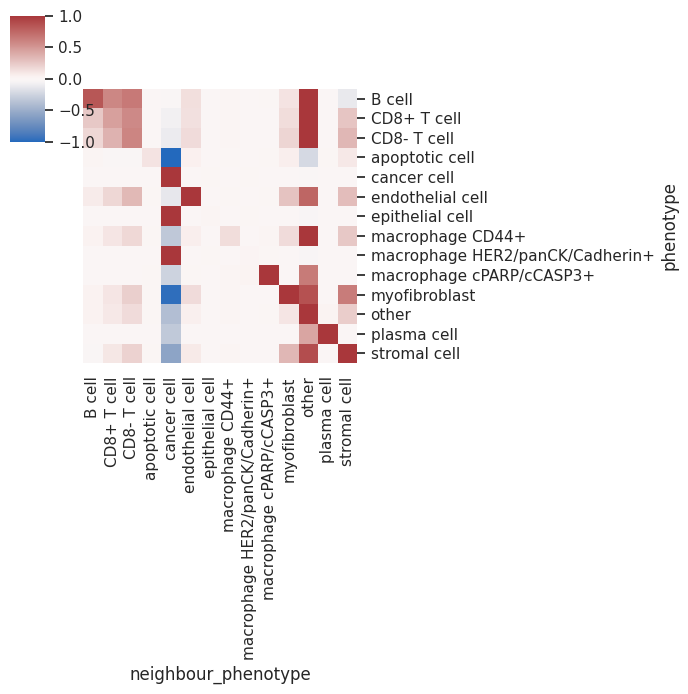

In [18]:
## Plot results using inbuilt function
## Showing the average interaction across all images
sm.pl.spatial_interaction(adata3, summarize_plot=True, p_val=None, figsize=(7,7))

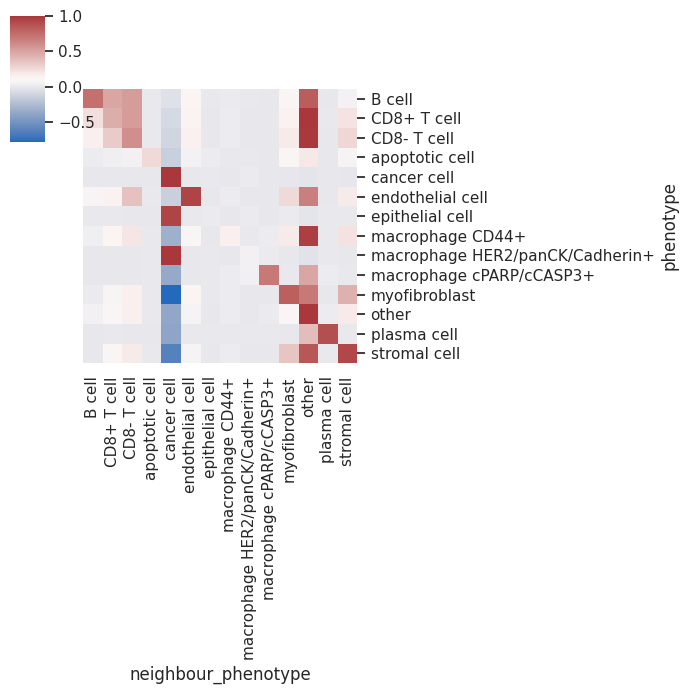

In [19]:
## Plot results using inbuilt function
## Showing the average interaction across all images
sm.pl.spatial_interaction(adata2, summarize_plot=True, p_val=None, figsize=(7,7))

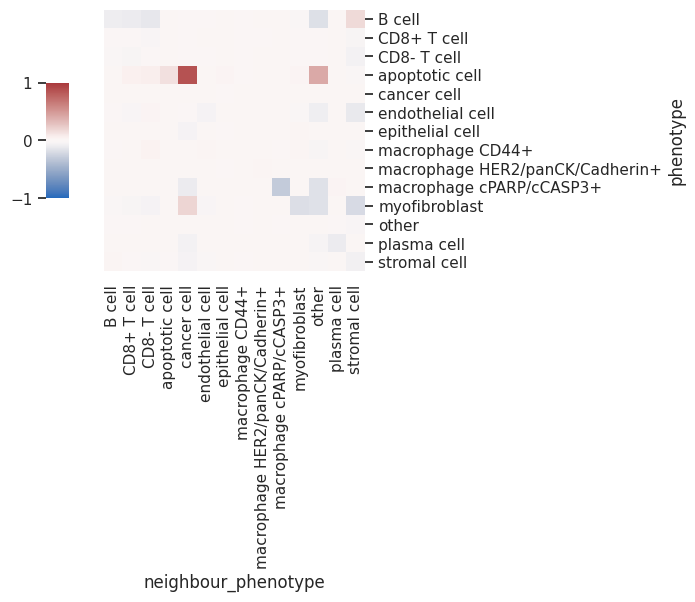

In [20]:
## Plot heatmap of differences
## Summarize 2D data as in scimap (mean)
si2 = pd.concat([adata2.uns['spatial_interaction']['phenotype'],
                    adata2.uns['spatial_interaction']['neighbour_phenotype'],
                    adata2.uns['spatial_interaction'][np.arange(0,152)].mean(axis=1)],
                    axis=1)
si2.columns = ['phenotype', 'neighbour_phenotype', 'mean_2D']

## Get difference between 2D and 3D
si32 = pd.merge(adata3.uns['spatial_interaction'][['phenotype','neighbour_phenotype','imageid']], si2,
         on=['phenotype', 'neighbour_phenotype'], how='outer')
si32['diff'] = si32['mean_2D'] - si32['imageid'] # TODO - check for NaN values, mask if present
si32 = si32.drop(['mean_2D', 'imageid'], axis=1).pivot(index='phenotype', columns='neighbour_phenotype', values='diff')

## Plot heatmap
#sns.clustermap(si32, cmap='coolwarm', figsize=(10,10)) ## with clustering
fig, ax = plt.subplots(figsize=(4.5,5))
sns.heatmap(si32, cmap='vlag', annot=False, ax=ax, square=True,
            vmin=-1, vmax=1, center=0, cbar_kws={'shrink':.3, 'aspect':5, 'location':'left', 'ticklocation':'right'})
ax.yaxis.tick_right()
plt.yticks(rotation=0, ha='left')
ax.yaxis.set_label_position("right")
plt.show()

Maybe the slices can capture changes in interaction along the z axis. Here is the plot with columns sorted by z:

In [53]:
def custom_interaction_plot(adata, spatial_interaction, pt_subset, figsize=(10,2)):
    interaction_map = adata.uns[spatial_interaction].copy()
    interaction_map.columns = interaction_map.columns.astype(str)
    interaction_map = interaction_map[[ col for col in interaction_map.columns if not col.startswith('pvalue_') ]]
    interaction_map = interaction_map[  interaction_map['phenotype'].isin(pt_subset) &
                                        interaction_map['neighbour_phenotype'].isin(pt_subset) ]
    interaction_map['phenotype'] = interaction_map['phenotype'].astype("category").cat.reorder_categories(pt_subset)
    interaction_map['neighbour_phenotype'] = interaction_map['neighbour_phenotype'].astype("category").cat.reorder_categories(pt_subset)
    interaction_map = interaction_map.set_index( ['phenotype', 'neighbour_phenotype'] )
    cmap = sns.color_palette("vlag", as_cmap=True)
    cmap.set_bad(color='gray')
    plot = sns.clustermap(  interaction_map,
                            cmap=cmap,
                            mask=interaction_map.isna(),
                            row_cluster=False,
                            col_cluster=False,
                            figsize=figsize)
    return plot

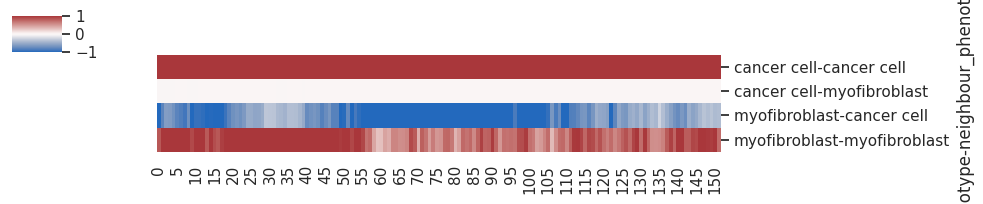

In [61]:
pt_subset = ['cancer cell', 'myofibroblast']
custom_interaction_plot(adata2, 'spatial_interaction', pt_subset)
plt.show()

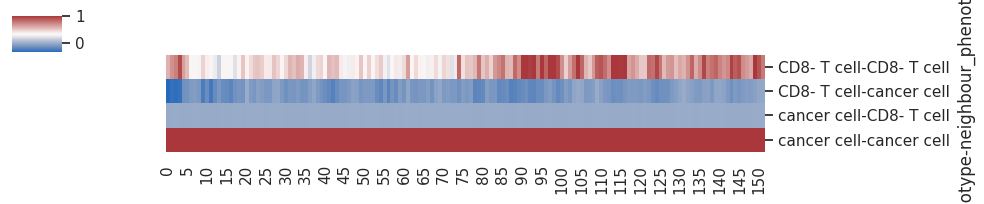

In [65]:
pt_subset = ['cancer cell', 'CD8- T cell']
custom_interaction_plot(adata2, 'spatial_interaction', pt_subset)
plt.show()

## Using `directionalSEA`

In [30]:
# Import dirSEA from git submodules
import sys
from pathlib import Path

dirSEA_path = Path("../submodules/directionalSEA/scimap/scimap/tools").resolve()
if str(dirSEA_path) not in sys.path:
    sys.path.append(str(dirSEA_path))

from spatial_interaction import spatial_interaction as dirSEA

In [5]:
knn_2D, knn_3D

(5, 17)

### Phenotypes from Kuett et al. (2021)

In [31]:
## Pattern1 (T cells, endothelial cells)
t0 = time.process_time()
dirSEA(adata2, x_coordinate='x', y_coordinate='y', z_coordinate=None, imageid='z', phenotype='pattern1', label='dirSEA_pattern1',
       method='knn', knn=knn_2D, permutation=1000, pval_method='zscore', normalization = 'conditional', verbose=False)
print("Time elapsed for 2D data: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

t0 = time.process_time()
dirSEA(adata3, x_coordinate='x', y_coordinate='y', z_coordinate='z', imageid='imageid', phenotype='pattern1', label='dirSEA_pattern1',
       method='knn', knn=knn_3D, permutation=1000, pval_method='zscore', normalization = 'conditional', verbose=False)
print("Time elapsed for 3D data: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

n_freq: phenotype    neighbour_phenotype
T            T                      1.342105
             endothelial            1.500000
             other                  2.982143
endothelial  T                      1.000000
             endothelial            1.636364
dtype: float64
mean: 0    1.034853
1    0.980996
2    3.842696
3    1.003586
4    0.860783
dtype: float64
std: 0    0.112788
1    0.234042
2    0.051942
3    0.216316
4    0.383125
dtype: float64
[  2.72416239   2.21757052 -16.56744756  -0.01657629   2.02435381]
n_freq: phenotype    neighbour_phenotype
T            T                      1.425532
             endothelial            1.222222
             other                  2.916667
endothelial  T                      1.111111
             endothelial            1.969697
dtype: float64
mean: 0    1.047655
1    1.023695
2    3.815832
3    1.038064
4    0.986003
dtype: float64
std: 0    0.086978
1    0.113994
2    0.048860
3    0.127748
4    0.214544
dtype: float64
[  4.3445

KeyboardInterrupt: 

In [118]:
## Save results
adata2.uns['dirSEA_pattern1'].to_csv('../../data/temp/Kuett_2022_dirSEA_pattern1_2D.csv', sep=',', index=False)
adata3.uns['dirSEA_pattern1'].to_csv('../../data/temp/Kuett_2022_dirSEA_pattern1_3D.csv', sep=',', index=False)

In [9]:
## Pattern2 (CD68+ subtypes)
t0 = time.process_time()
dirSEA(adata2, x_coordinate='x', y_coordinate='y', z_coordinate=None, imageid='z', phenotype='pattern2', label='dirSEA_pattern2',
       method='knn', knn=knn_2D, permutation=1000, pval_method='zscore', normalization = 'conditional', verbose=False)
print("Time elapsed for 2D data: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

t0 = time.process_time()
#dirSEA(adata3, x_coordinate='x', y_coordinate='y', z_coordinate='z', imageid='imageid', phenotype='pattern2', label='dirSEA_pattern2',
#       method='knn', knn=knn_3D, permutation=1000, pval_method='zscore', normalization = 'conditional', verbose=False)
print("Time elapsed for 3D data: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

Time elapsed for 2D data:  00:04:56
Time elapsed for 3D data:  00:00:00


In [10]:
## Save results
adata2.uns['dirSEA_pattern2'].to_csv('../../data/temp/Kuett_2022_dirSEA_pattern2_2D.csv', sep=',', index=False)
adata3.uns['dirSEA_pattern2'].to_csv('../../data/temp/Kuett_2022_dirSEA_pattern2_3D.csv', sep=',', index=False)

In [6]:
## Load results
adata2.uns['dirSEA_pattern1'] = pd.read_csv('../../data/temp/Kuett_2022_dirSEA_pattern1_2D.csv')
adata3.uns['dirSEA_pattern1'] = pd.read_csv('../../data/temp/Kuett_2022_dirSEA_pattern1_3D.csv')
adata2.uns['dirSEA_pattern2'] = pd.read_csv('../../data/temp/Kuett_2022_dirSEA_pattern2_2D.csv')
adata3.uns['dirSEA_pattern2'] = pd.read_csv('../../data/temp/Kuett_2022_dirSEA_pattern2_3D.csv')

In [25]:
adata2.uns['dirSEA_pattern1']

,phenotype,neighbour_phenotype,zscore_0,pvalue_0,count_0,zscore_1,pvalue_1,count_1,zscore_2,pvalue_2,...,count_148,zscore_149,pvalue_149,count_149,zscore_150,pvalue_150,count_150,zscore_151,pvalue_151,count_151
0,T,T,2.737411,6.192486e-03,1.342105,4.386997,1.149264e-05,1.425532,6.303636,2.907436e-10,...,1.890244,25.014031,4.301867e-138,2.227979,23.774004,6.205061e-125,2.222772,17.986728,2.475488e-72,2.054054
1,T,endothelial,2.324429,2.010251e-02,1.500000,1.778770,7.527748e-02,1.222222,0.853076,3.936170e-01,...,1.266667,-0.361487,7.177356e-01,1.000000,4.110043,3.955855e-05,1.230769,2.528133,1.146708e-02,1.181818
2,T,other,-16.239099,2.668144e-59,2.982143,-17.909468,9.948177e-72,2.916667,-19.080056,3.698617e-81,...,2.351759,-32.230278,6.648176e-228,2.361386,-30.630844,4.755804e-206,2.422886,-27.787270,6.181786e-170,2.487654
3,endothelial,T,-0.047743,9.619207e-01,1.000000,0.527665,5.977317e-01,1.111111,1.243166,2.138068e-01,...,1.391304,0.186784,8.518298e-01,1.166667,3.723095,1.967958e-04,1.714286,2.575600,1.000663e-02,1.555556
4,endothelial,endothelial,2.002142,4.526942e-02,1.636364,4.626663,3.716047e-06,1.969697,3.149926,1.633121e-03,...,1.190476,2.018751,4.351306e-02,1.650000,2.402633,1.627752e-02,1.714286,2.225900,2.602086e-02,1.666667
5,endothelial,other,-17.864510,2.228823e-71,2.612903,-23.699988,3.606726e-124,2.404255,-19.280697,7.801804e-83,...,2.371429,-9.127579,7.004800e-20,2.612903,-9.158420,5.266285e-20,2.400000,-10.620601,2.390175e-26,2.250000
6,other,T,17.231700,1.535708e-66,1.278689,16.482788,4.878208e-61,1.254658,12.655173,1.047452e-36,...,1.559322,36.386595,6.936481e-290,1.608247,34.071218,1.969079e-254,1.585443,31.214747,6.721369e-214,1.583012
7,other,endothelial,27.608806,8.723226e-168,1.393443,30.436608,1.801657e-203,1.415584,28.755584,7.712674e-182,...,1.216667,14.177193,1.268191e-45,1.200000,10.546237,5.287253e-26,1.142857,12.505402,6.974593e-36,1.194444
8,other,other,23.900581,3.020446e-126,3.884634,30.289399,1.581046e-201,3.872796,31.927087,1.123919e-223,...,3.785745,44.530675,0.000000e+00,3.787633,44.946986,0.000000e+00,3.784280,38.055438,0.000000e+00,3.785218


In [15]:
adata3.uns['dirSEA_pattern1']

,phenotype,neighbour_phenotype,zscore_imageid,pvalue_imageid,count_imageid
0,T,T,366.268545,0.0,5.663090
1,T,endothelial,153.403099,0.0,2.650677
2,T,other,-407.194608,0.0,9.843431
3,endothelial,T,82.747915,0.0,3.259396
4,endothelial,endothelial,231.119840,0.0,5.298701
5,endothelial,other,-272.008397,0.0,8.198073
6,other,T,638.168945,0.0,2.911483
7,other,endothelial,582.554834,0.0,2.435568
8,other,other,492.282367,0.0,15.362505


In [24]:
adata2.uns['dirSEA_pattern1'].filter(like='zscore').mean(axis=None), adata3.uns['dirSEA_pattern1']['zscore_imageid'].mean()

(7.854303414807464, 207.48250445546768)

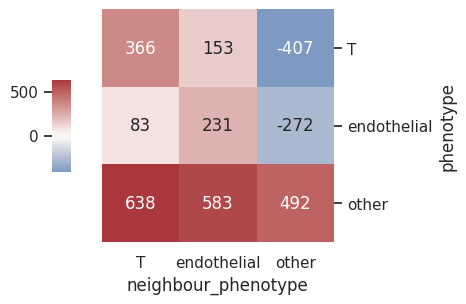

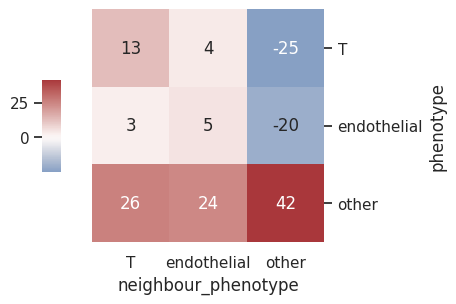

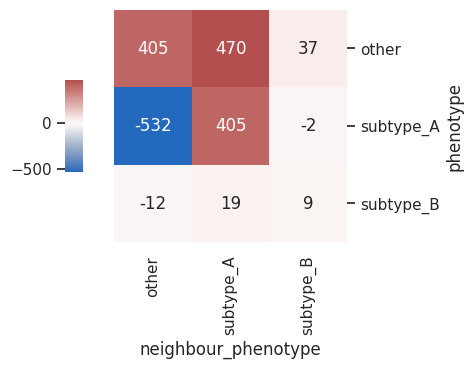

/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/matplotlib/colors.py:1405: RuntimeWarning:

invalid value encountered in divide



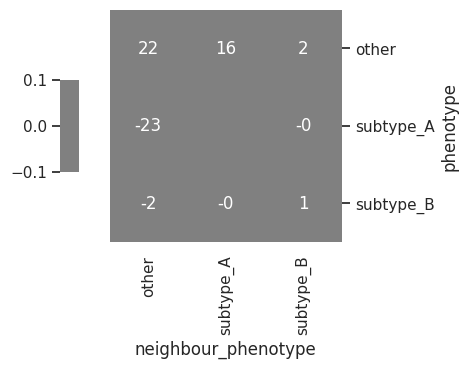

In [30]:
for (df_3D, df_2D) in [(adata3.uns['dirSEA_pattern1'], adata2.uns['dirSEA_pattern1']),
                        (adata3.uns['dirSEA_pattern2'], adata2.uns['dirSEA_pattern2'])]:
    zscores_3D = dirSEA_to_heatmap_data( df_3D , pval_threshold=1)
    zscores_2D = dirSEA_to_heatmap_data( df_2D , pval_threshold=1)

    ## Get/set min and max values of colorbar
    ## 3D images have more extreme z-scores on average, so the colorbar shouldn't be the same for both
    #vmax = 500 #max( np.nanmax(zscores_3D), np.nanmax(zscores_2D) ) ## capped here because of 'boosted' extreme values
    #vmin = min( np.nanmin(zscores_3D), np.nanmin(zscores_2D) )

    # Create a custom colormap
    cmap = sns.color_palette("vlag", as_cmap=True)
    cmap.set_bad(color='gray')  # Set the color for NA values to gray

    # Plot the heatmap
    for zscores in [zscores_3D, zscores_2D]:
        fig, ax = plt.subplots(figsize=(4,4))
        sns.heatmap(ax=ax,
                        data=zscores, mask=zscores.isna(),
                        annot=True, fmt=".0f",
                        cmap=cmap, center=0, #vmin=vmin, vmax=vmax,
                        cbar_kws={'shrink':.3, 'aspect':5, 'location':'left', 'ticklocation':'right'},
                        square=True)
        ax.yaxis.tick_right()
        plt.yticks(rotation=0, ha='left')
        ax.yaxis.set_label_position("right")

        # Save the plot as SVG
        #plt.savefig(outfile, format='svg', bbox_inches='tight')
        plt.show()  

### Own phenotypes

In [67]:
t0 = time.process_time()
dirSEA(adata2, x_coordinate='x', y_coordinate='y', z_coordinate=None, imageid='z', phenotype='ct_broad', label='dirSEA',
       method='knn', knn=knn_2D, permutation=1000, pval_method='zscore', normalization = 'conditional', verbose=False)
print("Time elapsed for 2D data: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

t0 = time.process_time()
dirSEA(adata3, x_coordinate='x', y_coordinate='y', z_coordinate='z', imageid='imageid', phenotype='ct_broad', label='dirSEA',
       method='knn', knn=knn_3D, permutation=1000, pval_method='zscore', normalization = 'conditional', verbose=False)
print("Time elapsed for 3D data: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

Time elapsed for 2D data:  00:15:11
Time elapsed for 3D data:  00:06:45


In [70]:
## Save results
adata2.uns['dirSEA'].to_csv('../../data/temp/Kuett_2022_dirSEA_2D.csv', sep=',', index=False)
adata3.uns['dirSEA'].to_csv('../../data/temp/Kuett_2022_dirSEA_3D.csv', sep=',', index=False)

In [69]:
adata2.uns['dirSEA']

,phenotype,neighbour_phenotype,zscore_0,pvalue_0,count_0,zscore_1,pvalue_1,count_1,zscore_2,pvalue_2,...,count_148,zscore_149,pvalue_149,count_149,zscore_150,pvalue_150,count_150,zscore_151,pvalue_151,count_151
0,B cell,B cell,5.783535,7.314701e-09,1.000000,4.224933,2.390122e-05,1.000000,-0.105410,9.160506e-01,...,1.600000,2.299861,2.145612e-02,1.642857,1.752809,7.963480e-02,1.521739,0.993584,3.204255e-01,1.166667
1,B cell,CD8+ T cell,2.519684,1.174602e-02,1.000000,1.943318,5.197770e-02,1.000000,2.843288,4.465063e-03,...,1.363636,0.625948,5.313492e-01,1.136364,2.083828,3.717584e-02,1.333333,1.311608,1.896526e-01,1.333333
2,B cell,CD8- T cell,1.737332,8.232855e-02,1.000000,1.203255,2.288778e-01,1.000000,1.612014,1.069588e-01,...,1.458333,3.914579,9.056200e-05,1.521739,3.552056,3.822337e-04,1.481481,3.120684,1.804317e-03,1.611111
3,B cell,apoptotic cell,-0.095250,9.241159e-01,0.000000,6.241875,4.323572e-10,1.000000,-0.083918,9.331213e-01,...,0.000000,-0.432967,6.650384e-01,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,B cell,cancer cell,-5.988988,2.111505e-09,0.000000,-7.942290,1.984827e-15,0.000000,-3.435801,5.908051e-04,...,0.000000,-17.936366,6.133796e-72,0.000000,-16.888731,5.446177e-64,0.000000,-14.300358,2.176874e-46,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,stromal cell,macrophage cPARP/cCASP3+,1.087301,2.769040e-01,1.000000,-0.765973,4.436925e-01,0.000000,-0.640333,5.219559e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.044055,2.964599e-01,0.000000
192,stromal cell,myofibroblast,5.463907,4.657685e-08,1.306452,7.476118,7.655019e-14,1.428571,5.892193,3.811029e-09,...,1.171429,4.797339,1.607877e-06,1.323529,5.569449,2.555459e-08,1.371429,5.117343,3.098698e-07,1.333333
193,stromal cell,other,10.431800,1.774937e-25,1.637795,9.208389,3.310554e-20,1.595041,6.378146,1.792450e-10,...,1.618557,7.225016,5.010415e-13,1.717647,7.077213,1.470827e-12,1.674157,6.377369,1.801565e-10,1.660000
194,stromal cell,plasma cell,0.021015,9.832337e-01,1.000000,-16.006174,1.157098e-57,0.000000,-9.605547,7.575489e-22,...,0.000000,-0.891384,3.727231e-01,0.000000,0.557549,5.771525e-01,1.000000,0.674997,4.996780e-01,1.000000


In [71]:
adata3.uns['dirSEA']

,phenotype,neighbour_phenotype,zscore_imageid,pvalue_imageid,count_imageid
0,B cell,B cell,143.621830,0.000000,4.285078
1,B cell,CD8+ T cell,75.984939,0.000000,3.077185
2,B cell,CD8- T cell,81.777566,0.000000,3.325633
3,B cell,apoptotic cell,-0.226893,0.820507,1.000000
4,B cell,cancer cell,-146.214401,0.000000,2.750000
...,...,...,...,...,...
191,stromal cell,macrophage cPARP/cCASP3+,53.346761,0.000000,1.500000
192,stromal cell,myofibroblast,120.015274,0.000000,2.512711
193,stromal cell,other,150.474185,0.000000,4.744843
194,stromal cell,plasma cell,1.406378,0.159612,1.068966


### Analysis of results

In [28]:
## Load results
adata2.uns['dirSEA'] = pd.read_csv('../../data/temp/Kuett_2022_dirSEA_2D.csv')
adata3.uns['dirSEA'] = pd.read_csv('../../data/temp/Kuett_2022_dirSEA_3D.csv')

In [7]:
## Custom function to plot heatmap from dirSEA data
## This is necessary to set a common vmin/vmax for both 2D and 3D
## since the scimap function changes the values
# TODO - how? issue if found

def dirSEA_to_heatmap_data(df,
    pt_subset=None,             ## subset of phenotypes/neighbour_phenotypes to include
    pval_threshold=0.05,        ## None or float; which z-scores to mask in heatmap based on p-value (will be filtered after aggregation) TODO
    imageid='all',              ## 'all' or subset of imageid
    zscore_agg_method='mean',   ## required if multiple imageids should be included; ['mean']; NaN values will be ignored
    pval_agg_method='mean'):    ## required if multiple imageids should be included; ['mean']; NaN values will be ignored
    # TODO - for aggregation, should NaN values be ignored? (esp. for pvals, might overestimate significance)
    
    ## Subset by phenotype & neighbour_phenotype
    if pt_subset is not None: 
        df = df.loc[ df['phenotype'].isin(pt_subset) & df['neighbour_phenotype'].isin(pt_subset), : ]

    pvals = df.set_index(['phenotype', 'neighbour_phenotype']).filter(like='pvalue_')
    zscores = df.set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore_')

    ## Subset by imageid
    pvals.columns = pvals.columns.str.replace('pvalue_', '')
    zscores.columns = zscores.columns.str.replace('zscore_', '')
    if len(zscores.columns)>1: ## >1 image present
        if type(imageid)==list: ## Imageids specified
            assert all([img in zscores.columns for img in imageid]), "Imageid not found in data (also check type)"
            zscores = zscores.loc[ :, imageid ]
            pvals = pvals.loc[ :, imageid ]

    ## Aggregate scores of multiple images
    if len(zscores.columns)>1:
        if zscore_agg_method=='mean':
            zscores = pd.Series(np.nanmean(zscores, axis=1), index=zscores.index)
        if pval_agg_method=='mean':
            pvals = pd.Series(np.nanmean(pvals, axis=1), index=pvals.index)
    else: ## remove imageid name, convert to pd.Series
        zscores = pd.Series(zscores[zscores.columns[0]], name=0)
    
    ## Set z-score to NaN (for mask) if p-value below threshold
    zscores.loc[ pvals.index[ (pvals >= pval_threshold).squeeze() ] ] = np.nan

    ## To square matrix
    zscores = zscores.reset_index(drop=False).pivot(index='phenotype',columns='neighbour_phenotype', values=0)

    return zscores


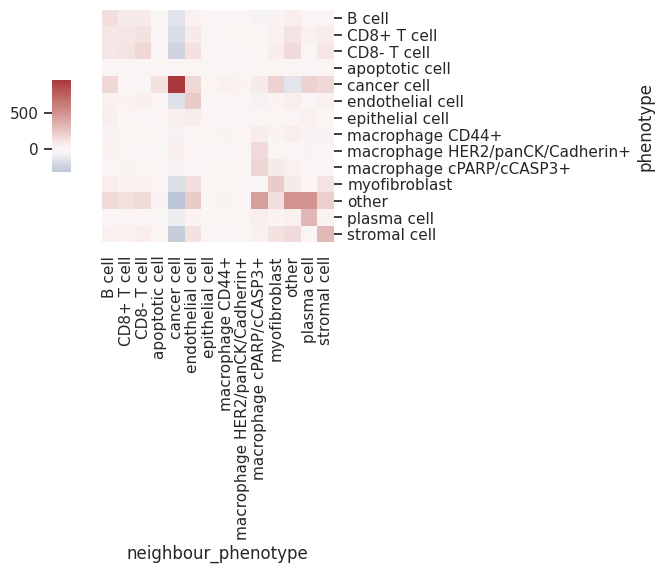

/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/matplotlib/colors.py:1405: RuntimeWarning:

invalid value encountered in divide



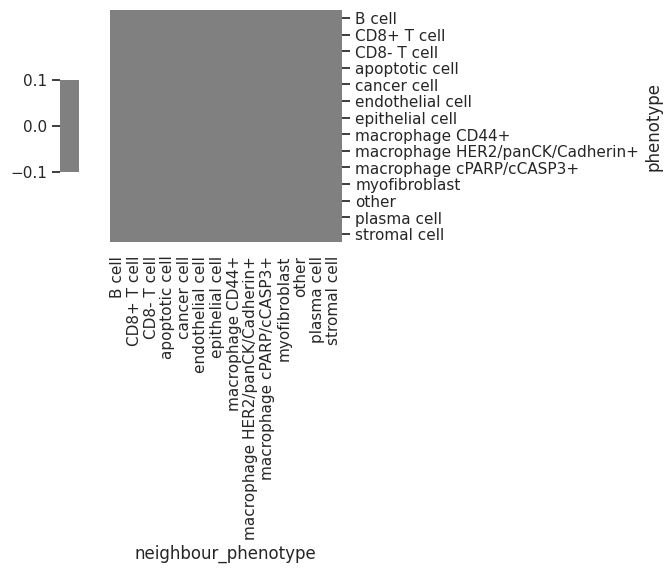

In [29]:
## Plot
## Get dataframes for heatmap
zscores_3D = dirSEA_to_heatmap_data(adata3.uns['dirSEA'].copy(), pval_threshold=1)
zscores_2D = dirSEA_to_heatmap_data(adata2.uns['dirSEA'].copy(),
                                    imageid='all',
                                    zscore_agg_method='mean',
                                    pval_agg_method='mean',
                                    pval_threshold=1) # TODO - add more options (e.g., Stouffer?)

## Get extrema of z-scores for colorbar
#vmax = max( np.nanmax(zscores_3D), np.nanmax(zscores_2D) )
#vmax = 500
#vmin = min( np.nanmin(zscores_3D), np.nanmin(zscores_2D) )



# Create a custom colormap
cmap = sns.color_palette("vlag", as_cmap=True)
cmap.set_bad(color='gray')  # Set the color for NA values to gray

# Plot the heatmap
for zscores in [zscores_3D, zscores_2D]:
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(ax=ax,
                data=zscores, mask=zscores.isna(),
                cmap=cmap, center=0, #vmin=vmin, vmax=vmax,
                cbar_kws={'shrink':.3, 'aspect':5, 'location':'left', 'ticklocation':'right'},
                square=True)
    ax.yaxis.tick_right()
    plt.yticks(rotation=0, ha='left')
    ax.yaxis.set_label_position("right")

    # Save the plot as SVG
    #plt.savefig("./../../SCNA_thesis/Paper_figures/dirSEA_v2/MI_mon_endocard_heatmap_dirSEA.svg", format='svg', bbox_inches='tight')
    plt.show()  

In [ ]:
# TODO - modify where needed
## Plot heatmap of differences
## Summarize 2D data as in scimap (mean)
si2 = pd.concat([adata2.uns['dirSEA']['phenotype'],
                    adata2.uns['dirSEA']['neighbour_phenotype'],
                    adata2.uns['dirSEA'].filter(like='zscore').mean(axis=1)), #['zscore_' + np.arange(0,152).astype(str)].mean(axis=1)],
                    axis=1)
si2.columns = ['phenotype', 'neighbour_phenotype', 'mean_2D']

## Get difference between 2D and 3D
si32 = pd.merge(adata3.uns['dirSEA'][['phenotype','neighbour_phenotype','imageid']], si2,
         on=['phenotype', 'neighbour_phenotype'], how='outer')
si32['diff'] = si32['mean_2D'] - si32['imageid'] # TODO - check for NaN values, mask if present
si32 = si32.drop(['mean_2D', 'imageid'], axis=1).pivot(index='phenotype', columns='neighbour_phenotype', values='diff')

## Plot heatmap
fig, ax = plt.subplots(figsize=(4.5,5))
sns.heatmap(si32, cmap='vlag', annot=False, ax=ax, square=True,
            vmin=-1, vmax=1, center=0, cbar_kws={'shrink':.3, 'aspect':5, 'location':'left', 'ticklocation':'right'})
ax.yaxis.tick_right()
plt.yticks(rotation=0, ha='left')
ax.yaxis.set_label_position("right")
plt.show()

In [ ]:
pt_subset=None,             ## subset of phenotypes/neighbour_phenotypes to include
    pval_threshold=0.05,        ## None or float; which z-scores to mask in heatmap based on p-value (will be filtered after aggregation) TODO
    imageid='all',              ## 'all' or subset of imageid
    zscore_agg_method='mean',   ## required if multiple imageids should be included; ['mean']; NaN values will be ignored
    pval_agg_method='mean'):    ## required if multiple imageids should be included; ['mean']; NaN values will be ignored
    # TODO - for aggregation, should NaN values be ignored? (esp. for pvals, might overestimate significance)
    
    ## Subset by phenotype & neighbour_phenotype
    if pt_subset is not None: 
        df = df.loc[ df['phenotype'].isin(pt_subset) & df['neighbour_phenotype'].isin(pt_subset), : ]

    pvals = df.set_index(['phenotype', 'neighbour_phenotype']).filter(like='pvalue_')
    zscores = df.set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore_')

    ## Subset by imageid
    pvals.columns = pvals.columns.str.replace('pvalue_', '')
    zscores.columns = zscores.columns.str.replace('zscore_', '')
    if len(zscores.columns)>1: ## >1 image present
        if type(imageid)==list: ## Imageids specified
            assert all([img in zscores.columns for img in imageid]), "Imageid not found in data (also check type)"
            zscores = zscores.loc[ :, imageid ]
            pvals = pvals.loc[ :, imageid ]

    ## Aggregate scores of multiple images
    if len(zscores.columns)>1:
        if zscore_agg_method=='mean':
            zscores = pd.Series(np.nanmean(zscores, axis=1), index=zscores.index)
        if pval_agg_method=='mean':
            pvals = pd.Series(np.nanmean(pvals, axis=1), index=pvals.index)
    else: ## remove imageid name, convert to pd.Series
        zscores = pd.Series(zscores[zscores.columns[0]], name=0)
    
    ## Set z-score to NaN (for mask) if p-value below threshold
    zscores.loc[ pvals.index[ (pvals >= pval_threshold).squeeze() ] ] = np.nan

    ## To square matrix
    zscores = zscores.reset_index(drop=False).pivot(index='phenotype',columns='neighbour_phenotype', values=0)


In [96]:
def custom_interaction_plot_dirSEA(adata,
                                   spatial_interaction, ## keyword under adata.obs
                                   pt_subset, ## subset of phenotypes/neighbour_phenotypes to include
                                   figsize=(10,2),
                                   vmax=None, vmin=None, center=0): ## colorbar max, min, and central values
    df = adata.uns[spatial_interaction].copy()
    
    if pt_subset is not None: 
        df = df.loc[ df['phenotype'].isin(pt_subset) & df['neighbour_phenotype'].isin(pt_subset), : ]

    pvals = df.set_index(['phenotype', 'neighbour_phenotype']).filter(like='pvalue_')
    zscores = df.set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore_')
    # TODO - mask z-scores based on p-values

    zscores.columns = zscores.columns.str.replace('zscore_', '') ## colnames == imageid
    zscores['phenotype - neighbour_phenotype'] = [ index[0] + " - " + index[1] for index in zscores.index ]
    zscores.set_index('phenotype - neighbour_phenotype', drop=True, inplace=True)

    cmap = sns.color_palette("vlag", as_cmap=True)
    cmap.set_bad(color='gray')
    plot = sns.clustermap(  zscores,
                            cmap=cmap,
                            mask=zscores.isna(),
                            center = 0,
                            row_cluster=False,
                            col_cluster=False,
                            figsize=figsize,
                            vmin=vmin, vmax=vmax, center=0)
    return plot

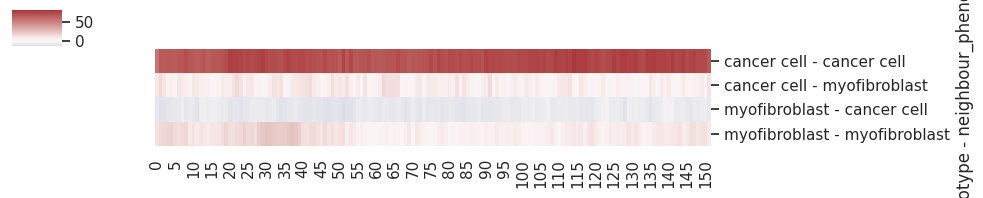

In [97]:
pt_subset = ['cancer cell', 'myofibroblast']
custom_interaction_plot_dirSEA(adata2, 'dirSEA', pt_subset, vmax=20) ## setting lower vmax to also distinguish differences outside of cancer-cancer
plt.show()

## Aggregating the interaction results from 2D data

For the scimap score:
1. Mean
    - used in scimap (for plotting)
1. Weighted mean
    - different options for weights:
        1. n_cells per image (here: very evenly distributed)
        1. n_cells of one of the cell types (which?)
        1. (1 - sdev) of score distribution per image
        1. other ?
1. Other?

For the p-value:
- note: p-values calculated by scimap: `p_values = scipy.stats.norm.sf(abs(z_scores))*2`
    - sf (surival function) is approximation of CDF
    - why `*2`?
1. Mean
1. Stouffer's method to combine p-values
    - different implementations:
        1. `scipy.stats.combine_pvalues(method='Stouffer')`
            - given p-values, calculates z-scores based on CDF of normal distribution
            - result: many p-values == 0.0
        1. manual calculation based on actual z-scores (modified scimap function to output z-scores)
        - results (see below): just mean most conservative, others similar, but stouffer smallest p-values
    - can integrate weights per z-score
        - possible weights here: (1 - fraction of shared cells) to account for correlation between images
        - TODO - try
    - if no weights given (all equal), simplifies to avg of z-scores --> avg of p-values
        - @Lukas: without weights, are results different than simple avg?
1. Other?


Options to compare 2D & 3D data:
- scimap count
    - t-test to compare mean counts between 2D & 3D (req.: mean, sdev, n)
        - 2D provides counts per slice, mean of counts is used in plot
        - 3D only one count value, would need to get sdev from modified function
        - n is not 'fair': 43 images in 2D, ~108k cells in 3D
        - different variances: use Welch's t-test
        - closest to simple interpretation of scimap score using multiple 2D slices
    - ... (indiv. 2D images vs 3D)
- z-scores
    - Welch's t-test to compare z-scores (indiv. 2D images vs 3D) (req.: zscore, mean, sdev)
        - modify function to get req. values
- n_freq (for every image, for every index ct, counts for all neighbor cts)
    - ...
        - very far from scimap fct

#### Fraction of shared cells between 2D images

In [173]:
## Calculate the fraction of cell labels that are present in both images
## Note: This is the data used for scimap, with single entries removed
# TODO - speed up (precompute sets? isin?)
cell_id = 'id'
image_id = 'z'

image_ids = data2D['z'].unique()
n_img = len(image_ids)
corr_mat = np.zeros((n_img, n_img), dtype=float)
for i in range(n_img):
    corr_mat[i, i] = 1
    for j in range(i + 1, n_img):
        ## Get number of shared cell IDs
        set_i = set( data2D.loc[ data2D[image_id] == image_ids[i], cell_id ] )
        set_j = set( data2D.loc[ data2D[image_id] == image_ids[j], cell_id ] )
        intersection_count = len( set_i.intersection(set_j) )
        
        corr_mat[i, j] = intersection_count / len(set_i) if len(set_i) != 0 else 0
        corr_mat[j, i] = intersection_count / len(set_j) if len(set_j) != 0 else 0

corr_df = pd.DataFrame(corr_mat, index=image_ids, columns=image_ids)
#corr_df.to_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/fraction_of_cells_shared.csv', sep=',', index=True) ## save

In [ ]:
## Load data if previously saved
corr_df = pd.read_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/fraction_of_cells_shared.csv', index_col=0)
corr_mat = corr_df.values
image_ids = np.values( corr_df.index )

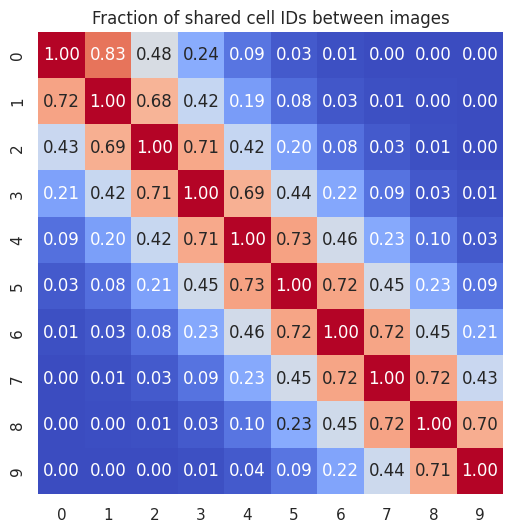

In [6]:
## Plot (portion of) correlation matrix as heatmap
plt.figure(figsize=(6,6))
sns.heatmap(corr_df.iloc[:10,:10], annot=True, fmt=".2f", cmap='coolwarm', cbar=False)
plt.title('Fraction of shared cell IDs between images')
plt.show()

#### Get z-scores from scimap function

In [7]:
## Get z-scores using modified scimap function
from scimap_spatial_interaction import spatial_interaction as spatial_interaction_zscore

t0 = time.process_time()
spatial_interaction_zscore(adata2, x_coordinate='x', y_coordinate='y', z_coordinate=None, imageid='z', phenotype='ct_broad', label='spatial_interaction_zscore',
                          method='knn', knn=knn_2D, permutation=1000, pval_method='zscore', verbose=False)
print(f"Time elapsed: {(time.process_time()-t0):.2} s" )

#adata2.uns['spatial_interaction_zscore'].to_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/spatial_interaction_2D_zscore.csv', sep=',', index=False) ## save

Time elapsed: 1.1e+03 s


In [174]:
## Load data if previously saved
adata2.uns['spatial_interaction_zscore'] = pd.read_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/spatial_interaction_2D_zscore.csv')

In [175]:
adata2.uns['spatial_interaction_zscore']

,phenotype,neighbour_phenotype,0,zscore_0,pvalue_0,1,zscore_1,pvalue_1,2,zscore_2,...,pvalue_148,149,zscore_149,pvalue_149,150,zscore_150,pvalue_150,151,zscore_151,pvalue_151
0,B,B,0.142857,7.552325,4.275546e-14,0.307692,9.832904,8.124138e-23,-0.000000,-0.190350,...,1.119623e-132,0.434211,25.383013,3.884475e-142,0.305195,19.247614,1.478158e-82,0.263736,13.039872,7.257852e-39
1,B,CD86+,-0.000000,-0.503089,6.149017e-01,-0.000000,-0.708353,4.787258e-01,-0.000000,-0.513760,...,2.678505e-02,-0.000000,-1.922537,5.453817e-02,-0.000000,-1.192937,2.328942e-01,-0.000000,-0.847879,3.965051e-01
2,B,T,0.142857,1.231259,2.182262e-01,0.846154,8.169876,3.087070e-16,1.000000,5.647232,...,9.254248e-84,1.000000,21.733917,9.807031e-105,1.000000,24.428870,8.441513e-132,1.000000,18.153727,1.199781e-73
3,B,endothelial,0.214286,3.315518,9.147330e-04,0.230769,1.973492,4.843957e-02,0.500000,3.565799,...,9.968261e-09,0.039474,0.975405,3.293595e-01,0.025974,1.156315,2.475523e-01,-0.021978,-0.032708,9.739075e-01
4,B,epithelial,-0.000000,-5.671262,1.417492e-08,-0.230769,-7.885414,3.134946e-15,-0.500000,-5.706452,...,3.883974e-83,-0.019737,-19.029439,9.728850e-81,-0.012987,-18.838410,3.657890e-79,-0.032967,-15.597642,7.553263e-55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,stromal,label_37,NaN,NaN,NaN,-0.000000,-0.978158,3.279961e-01,-0.000000,-1.097314,...,5.941801e-02,-0.000000,-2.908820,3.627954e-03,-0.000000,-2.848729,4.389428e-03,-0.000000,-2.498268,1.248020e-02
725,stromal,label_8,0.015625,1.455205,1.456125e-01,0.009950,0.522444,6.013610e-01,0.008658,1.278364,...,4.232128e-01,0.079208,1.182396,2.370486e-01,0.096447,2.655916,7.909337e-03,0.190476,4.041450,5.312176e-05
726,stromal,label_9,0.281250,4.976235,6.483294e-07,0.179104,2.561323,1.042744e-02,0.155844,2.632739,...,3.444406e-05,0.262376,6.577153,4.795412e-11,0.345178,8.880570,6.651854e-19,0.341270,6.922438,4.439371e-12
727,stromal,macrophage,-0.000000,-0.613583,5.394911e-01,-0.000000,-0.954147,3.400094e-01,-0.000000,-0.797124,...,NaN,NaN,NaN,NaN,-0.000000,-0.252659,8.005316e-01,-0.000000,-0.749750,4.534054e-01


#### Combine p-values using different methods

In [333]:
## Calculate combined p-value
from scipy import stats

## Split z-scores and p-values, columns sorted by image_id
#si_scores = adata2.uns['spatial_interaction_zscore'][ np.append(['phenotype', 'neighbour_phenotype'], image_ids)] ## FIXME - the score column names here are integers, not strings
si_zscores = adata2.uns['spatial_interaction_zscore'][ np.append(['phenotype', 'neighbour_phenotype'], ['zscore_'+col for col in image_ids.astype(str)])]
si_pval = adata2.uns['spatial_interaction_zscore'][ np.append(['phenotype', 'neighbour_phenotype'], ['pvalue_'+col for col in image_ids.astype(str)])]

## Calculate p-value
from scipy.stats import norm 
zscore_mean = si_zscores.set_index(['phenotype', 'neighbour_phenotype']).mean(axis=1)

pval_just_mean = si_pval.set_index(['phenotype', 'neighbour_phenotype']).mean(axis=1)
pval_from_zscore = (stats.norm.sf(abs( zscore_mean ))*2 ) ## as calculated in scimap
pval_scipy_stouffer = np.empty_like(pval_just_mean)
for i, row in si_pval.iterrows():
    pvals = row[2:].values.astype(float)
    pval_scipy_stouffer[i] = stats.combine_pvalues( pvals[ ~np.isnan(pvals) ], method='stouffer', weights=None )[1]

pval_comparison = pd.concat({'just_mean': pd.Series(pval_just_mean, index=pval_just_mean.index),
                            'from_zscore': pd.Series(pval_from_zscore, index=zscore_mean.index),
                            'scipy_stouffer': pd.Series(pval_scipy_stouffer, index=zscore_mean.index)},
                            axis=1)
pval_comparison

just_mean    from_zscore  scipy_stouffer
phenotype neighbour_phenotype                                             
B         B                    2.846677e-02  5.719098e-151    0.000000e+00
          CD86+                2.411948e-01   2.108517e-01    1.750241e-22
          T                    1.484590e-03   4.823134e-89    0.000000e+00
          endothelial          1.063786e-01   8.145814e-05    0.000000e+00
          epithelial           1.072750e-06   3.238189e-66    0.000000e+00
...                                     ...            ...             ...
stromal   label_37             2.202451e-01   1.749741e-01    5.783771e-40
          label_8              7.959251e-02   1.250403e-05    0.000000e+00
          label_9              6.171235e-04   3.534898e-13    0.000000e+00
          macrophage           2.506247e-01   1.719375e-01    5.392562e-25
          stromal              2.818379e-35  1.828571e-215    0.000000e+00

[729 rows x 3 columns]

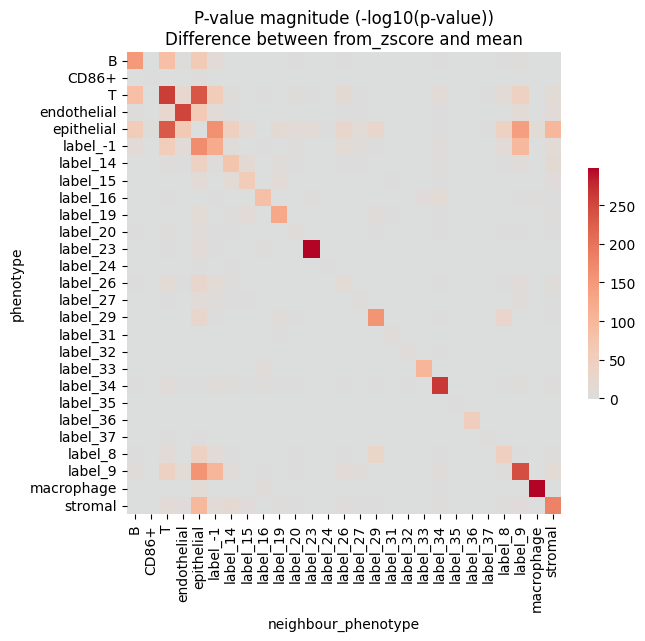

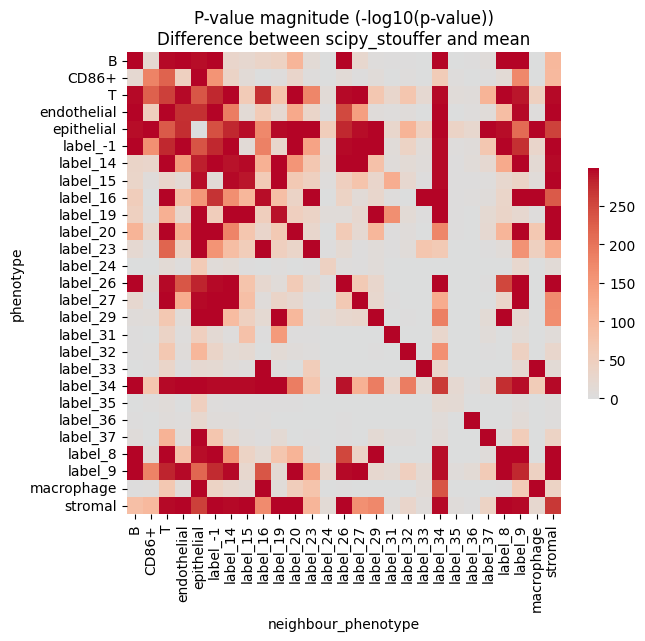

In [355]:
pval_cap = 1e-300 ## for log transform
for method in ['from_zscore', 'scipy_stouffer']:
    df = pval_comparison[['just_mean', method]].copy()
    df[ df<=pval_cap ] = pval_cap ## e.g., pval=0 -> pval=1e-300
    df = -np.log10(df)
    df['diff'] = df[method] - df['just_mean']
    mat = df['diff'].reset_index(drop=False).pivot(index='phenotype', columns='neighbour_phenotype', values='diff')

    ## Plot heatmap
    plt.figure(figsize=(7,6))
    sns.heatmap(mat, cmap='coolwarm', annot=False, center=0, cbar_kws={'shrink':.5})
    plt.title(f'P-value magnitude (-log10(p-value))\nDifference between {method} and mean')
    plt.show()

In [ ]:
## Plot
df = -np.log10( pval_comparison[ pval_comparison!=0 ] )
for lim in [100, -np.log10(0.05)]:
    plt.scatter(df.iloc[:,0], df.iloc[:,0], s=5, alpha=.5, color='black')
    plt.xlim(0,lim) ## exclude outlier
    plt.ylim(0,lim)
    plt.axline([0,0], [lim,lim], color='black', linestyle='--', linewidth=.2)
    plt.title('Different methods for combining p-values')
    plt.xlabel('mean of p-values\n-log10(p-value)')
    plt.ylabel('mean of z-scores, then transformed to p-value\n-log10(p-value)')
    plt.show()

## The two methods arrive at very similar results

### Power Analysis / Downsampling Approach

We have already seen that combining results from 2D data approximates the 3D results well in most cases. However, instead of using all 152 serial sections, we might want to image only some of the sections to save resources. When reducing the number of 2D sections used to aggregate a score, there are some parameters we need to set for a comparison:

1. Threshold at which the interaction is considered significant, here α  =  0.05 / n_tests  =  ...
2. Threshold at which the interaction strength is considered strong enough, here ...

In [302]:
cols_score

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151])

In [225]:
## Assess the effect of different sampling strategies & downsampling
# TODO
cols_score = adata2.obs['z'].unique()
si_scores = adata2.uns['spatial_interaction'][ np.append(['phenotype', 'neighbour_phenotype'], cols_score)]
si_pval = adata2.uns['spatial_interaction'][ np.append(['phenotype', 'neighbour_phenotype'], ['pvalue_'+col for col in cols_score.astype(str)])]

n_slices = len(cols_score)
idx_all = np.arange(n_slices)
rng = np.random.default_rng(42) 

si_scores.set_index(['phenotype', 'neighbour_phenotype'], inplace=True)
si_pval.set_index(['phenotype', 'neighbour_phenotype'], inplace=True)
si_scores.columns = idx_all ## easier indexing
si_pval.columns = idx_all ## columns are already sorted the same

indices = {'all': idx_all,
            'skip2':  np.arange(0, n_slices, 2),
            'skip5':  np.arange(0, n_slices, 5),
            'skip10': np.arange(0, n_slices, 10),
            'top-middle-bottom': np.array([0, (n_slices-1)//2, n_slices-1]),
            'random-50%': rng.choice(idx_all, size=n_slices//2, replace=False),
            'random-20%': rng.choice(idx_all, size=n_slices//5, replace=False),
            'random-10%': rng.choice(idx_all, size=n_slices//10, replace=False)}




#### Misc

In [296]:
## Aggregate results using mean
cols_score = adata2.obs['z'].unique()
si_scores = adata2.uns['spatial_interaction'][ np.append(['phenotype', 'neighbour_phenotype'], cols_score)]
si_pval = adata2.uns['spatial_interaction'][ np.append(['phenotype', 'neighbour_phenotype'], ['pvalue_'+col for col in cols_score.astype(str)])]

score2D_mean = si_scores[cols_score.astype(str)].mean(axis=1)
pval2D_mean = si_pval.iloc[:,2:].mean(axis=1)

## Combine results to table
pval_cap = 1e-300 ## for log transform
df_2D = pd.DataFrame({'phenotype':adata2.uns['spatial_interaction']['phenotype'],
                       'neighbour_phenotype':adata2.uns['spatial_interaction']['neighbour_phenotype'],
                       'score2D_mean':score2D_mean,
                       'pval2D_mean':pval2D_mean})
df_3D = adata3.uns['spatial_interaction'].rename({'imageid': 'score_3D',
                                                  'pvalue_imageid':'pval_3D'}, axis=1)
df_3D['pval_transf_3D'] = [ -np.log10(x) if x>=pval_cap else -np.log10(pval_cap) for x in df_3D['pval_3D'] ]
cmp_df = pd.merge(df_3D, df_2D, on=['phenotype', 'neighbour_phenotype'])
cmp_df 

,phenotype,neighbour_phenotype,score_3D,pval_3D,pval_transf_3D,score2D_mean,pval2D_mean
0,B,B,0.534025,0.000000e+00,300.000000,0.549770,2.909536e-02
1,B,CD86+,-0.000716,1.760096e-62,61.754464,0.000630,2.427853e-01
2,B,T,1.000000,0.000000e+00,300.000000,0.965618,1.450436e-03
3,B,endothelial,0.125939,0.000000e+00,300.000000,0.167149,1.075949e-01
4,B,epithelial,-0.035492,0.000000e+00,300.000000,-0.070632,7.132288e-07
...,...,...,...,...,...,...,...
724,stromal,label_37,-0.003584,1.424015e-114,113.846485,-0.000357,2.196396e-01
725,stromal,label_8,0.107448,0.000000e+00,300.000000,0.108239,7.972585e-02
726,stromal,label_9,0.378665,0.000000e+00,300.000000,0.347475,6.010381e-04
727,stromal,macrophage,-0.002039,1.539357e-125,124.812661,0.000146,2.511755e-01


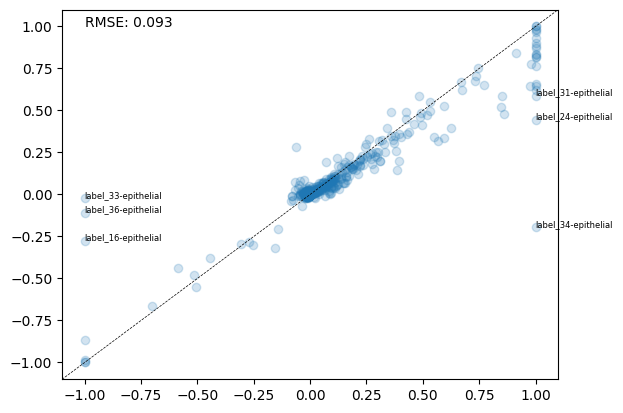

In [299]:
## Plot results as correlation
def modified_zscore_outliers(v0, v1, threshold=50):
    diff = v0 - v1
    median = np.median(diff)
    mad = np.median(np.abs(diff - median))
    if mad == 0:
        return np.array([False]*len(diff)) ## no outliers
    modified_z_scores = 0.6745 * (diff - median) / mad
    outliers = np.abs(modified_z_scores) > threshold
    return outliers

plt.figure()
plt.scatter(data=cmp_df, x='score_3D', y='score2D_mean',
                #c=cmp_df['pval_transf_3D'], cmap='coolwarm',
                alpha=.2)
plt.axline([-1,-1], [1, 1], color='black', linestyle='--', linewidth=.5)
#plt.colorbar(label='-log10(p-value)')
## Annotate outliers
outliers = modified_zscore_outliers(cmp_df['score_3D'], cmp_df['score2D_mean'])
for idx in cmp_df.index[outliers]:
    plt.text(x=cmp_df.loc[idx, 'score_3D'],
                y=cmp_df.loc[idx, 'score2D_mean'],
                s=cmp_df.loc[idx, 'phenotype']+'-'+cmp_df.loc[idx, 'neighbour_phenotype'],
                fontsize=6)
rmse = np.sqrt(np.mean((cmp_df['score_3D'] - cmp_df['score2D_mean'])**2))
plt.text(x=-1, y=1, s=f'RMSE: {rmse:.2}', fontsize=10)
plt.show()

# TODO - this is the same as the difference heatmap

Notes about the function:
- For knn, the underlying graph query function includes the index node itself, which is later excluded. Thus, in order to consider a neighborhood of knn=10 nearest neighbors around an index cell, actually, knn+1=11 should be passed to the scimap function.

In [44]:
from sklearn.neighbors import BallTree
from joblib import Parallel, delayed
import scipy

knn = knn_2D
method = 'knn'
z_coordinate = None
permutation = 1000
permutation_pval = 0.05
pval_method = 'zscore'
imageid = 'z'

adata_subset = ad.AnnData(obs=adata2.obs.loc[adata2.obs['z']==0, ['x','y','z','ct_broad']].rename({'ct_broad':'phenotype'}, axis='columns')) ## exemplary data
data = adata_subset.obs

#def spatial_interaction_internal (adata_subset,x_coordinate,y_coordinate,
#                                      z_coordinate,
#                                      phenotype,
#                                      method, radius, knn,
#                                      permutation, 
#                                      imageid,subset,
#                                      pval_method):
#        if verbose:
#            print("Processing Image: " + str(adata_subset.obs[imageid].unique()))
        
#        # Create a dataFrame with the necessary inforamtion
#        if z_coordinate is not None:
#            if verbose:
#                print("Including Z -axis")
#            data = pd.DataFrame({'x': adata_subset.obs[x_coordinate], 'y': adata_subset.obs[y_coordinate], 'z': adata_subset.obs[z_coordinate], 'phenotype': adata_subset.obs[phenotype]})
#        else:
#            data = pd.DataFrame({'x': adata_subset.obs[x_coordinate], 'y': adata_subset.obs[y_coordinate], 'phenotype': adata_subset.obs[phenotype]})

        
# Identify neighbourhoods based on the method used
# a) KNN method
if method == 'knn':
#    if verbose:
#        print("Identifying the " + str(knn) + " nearest neighbours for every cell")
    if z_coordinate is not None:
        tree = BallTree(data[['x','y','z']], leaf_size= 2)
        ind = tree.query(data[['x','y','z']], k=knn, return_distance= False)
    else:
        tree = BallTree(data[['x','y']], leaf_size= 2)
        ind = tree.query(data[['x','y']], k=knn, return_distance= False)
    neighbours = pd.DataFrame(ind.tolist(), index = data.index) # neighbour DF
    neighbours.drop(0, axis=1, inplace=True) # Remove self neighbour
    
# b) Local radius method
if method == 'radius':
#    if verbose:
#        print("Identifying neighbours within " + str(radius) + " pixels of every cell")
    if z_coordinate is not None:
        kdt = BallTree(data[['x','y','z']], metric='euclidean') 
        ind = kdt.query_radius(data[['x','y','z']], r=radius, return_distance=False)
    else:
        kdt = BallTree(data[['x','y']], metric='euclidean') 
        ind = kdt.query_radius(data[['x','y']], r=radius, return_distance=False)
        
    for i in range(0, len(ind)): ind[i] = np.delete(ind[i], np.argwhere(ind[i] == i))#remove self
    neighbours = pd.DataFrame(ind.tolist(), index = data.index) # neighbour DF
    
# Map Phenotypes to Neighbours
# Loop through (all functionized methods were very slow)
phenomap = dict(zip(list(range(len(ind))), data['phenotype'])) # Used for mapping
#if verbose:
#    print("Mapping phenotype to neighbors")
for i in neighbours.columns:
    neighbours[i] = neighbours[i].dropna().map(phenomap, na_action='ignore')
    
# Drop NA
neighbours = neighbours.dropna(how='all')

# Collapse all the neighbours into a single column
n = pd.DataFrame(neighbours.stack(), columns = ["neighbour_phenotype"])
n.index = n.index.get_level_values(0) # Drop the multi index

# Merge with real phenotype
n = n.merge(data['phenotype'], how='inner', left_index=True, right_index=True)

# Permutation
#if verbose:
#    print('Performing '+ str(permutation) + ' permutations')

def permutation_pval (data):
    data = data.assign(neighbour_phenotype=np.random.permutation(data['neighbour_phenotype']))
    #data['neighbour_phenotype'] = np.random.permutation(data['neighbour_phenotype'])
    data_freq = data.groupby(['phenotype','neighbour_phenotype'],observed=False).size().unstack()
    data_freq = data_freq.fillna(0).stack().values 
    return data_freq

# Apply function
final_scores = Parallel(n_jobs=-1)(delayed(permutation_pval)(data=n) for i in range(permutation)) 
perm = pd.DataFrame(final_scores).T

# Consolidate the permutation results
#if verbose:
#    print('Consolidating the permutation results')
# Calculate P value
# real
n_freq = n.groupby(['phenotype','neighbour_phenotype'],observed=False).size().unstack().fillna(0).stack() 
# permutation
mean = perm.mean(axis=1)
std = perm.std(axis=1)
# P-value calculation
if pval_method == 'abs':
    # real value - prem value / no of perm 
    p_values = abs(n_freq.values - mean) / (permutation+1)
    p_values = p_values[~np.isnan(p_values)].values
if pval_method == 'zscore':
    z_scores = (n_freq.values - mean) / std        
    z_scores[np.isnan(z_scores)] = 0
    p_values = scipy.stats.norm.sf(abs(z_scores))*2
    p_values = p_values[~np.isnan(p_values)]
    
# Compute Direction of interaction (interaction or avoidance)
direction = ((n_freq.values - mean) / abs(n_freq.values - mean)).fillna(1)

# Normalize based on total cell count
k = n.groupby(['phenotype','neighbour_phenotype'],observed=False).size().unstack().fillna(0)
# add neighbour phenotype that are not present to make k a square matrix
columns_to_add = dict.fromkeys(np.setdiff1d(k.index,k.columns), 0)
k = k.assign(**columns_to_add)

total_cell_count = data['phenotype'].value_counts()
total_cell_count = total_cell_count[k.columns].values # keep only cell types that are present in the column of k
# total_cell_count = total_cell_count.reindex(k.columns).values # replaced by above
k_max = k.div(total_cell_count, axis = 0)
k_max = k_max.div(k_max.max(axis=1), axis=0).stack()

# DataFrame with the neighbour frequency and P values
count = (k_max.values * direction).values # adding directionallity to interaction
neighbours = pd.DataFrame({'count': count,'p_val': p_values}, index = k_max.index)
#neighbours.loc[neighbours[neighbours['p_val'] > p_val].index,'count'] = np.NaN
#del neighbours['p_val']
neighbours.columns = [adata_subset.obs[imageid].unique()[0], 'pvalue_' + str(adata_subset.obs[imageid].unique()[0])]
neighbours = neighbours.reset_index()
#neighbours = neighbours['count'].unstack()


In [165]:
n_freq

phenotype  neighbour_phenotype
B          B                        2.0
           CD86+                    0.0
           T                        2.0
           endothelial              3.0
           epithelial               0.0
                                  ...  
stromal    label_36                 0.0
           label_8                  2.0
           label_9                 36.0
           macrophage               0.0
           stromal                128.0
Length: 576, dtype: float64

In [58]:
nbrs = pd.DataFrame({'count': count,'z_score': z_scores.values, 'p_val': p_values}, index = k_max.index)
nbrs.columns = [adata_subset.obs[imageid].unique()[0], 'zscore_' + str(adata_subset.obs[imageid].unique()[0]), 'pvalue_' + str(adata_subset.obs[imageid].unique()[0])]
nbrs

0   zscore_0       pvalue_0
phenotype neighbour_phenotype                                    
B         B                    0.142857   8.441969   3.120358e-17
          CD86+               -0.000000  -0.488235   6.253833e-01
          T                    0.142857   1.332348   1.827460e-01
          endothelial          0.214286   3.641901   2.706325e-04
          epithelial          -0.000000  -6.004168   1.923157e-09
...                                 ...        ...            ...
stromal   label_36            -0.000000  -0.830925   4.060158e-01
          label_8              0.015625   1.308289   1.907752e-01
          label_9              0.281250   5.138286   2.772561e-07
          macrophage          -0.000000  -0.602892   5.465803e-01
          stromal              1.000000  32.323756  3.244074e-229

[576 rows x 3 columns]

In [160]:
z_scores

0       7.275891
1      -0.520258
2       1.248564
3       3.558383
4      -5.617550
         ...    
571    -0.845499
572     1.364608
573     4.961167
574    -0.629990
575    31.353078
Length: 576, dtype: float64